# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


### Inclusion of all the necessary libraries

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
import sklearn

#from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from scipy import stats

import datetime

# magic word for producing visualizations in notebook
%matplotlib inline

### Cleaning functions



In [ ]:
#data cleaning
def str2float(x):
    if type(x)==str:
        return eval(x)
    else:
        return x

In [ ]:
def data_cleaning(df,clustering=False):
    '''
    Replace strings 
    Replace missing values to np.nan - data taken from the excel provided.
    Replace na with mean
    LNR set as index
    Removal of outliers
    Cleaning columns if it doesn't have enough data
    '''
    print(df.shape)
        
    for column in ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']:
        try:
            df[column] = df[column].replace(["X","XX"],np.nan)
        except:
            pass
        
    for column in ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']:
        df[column]=df[column].apply(str2float)
    
    #change the catergory columns into numbertraining
    for column in ["CAMEO_DEU_2015","D19_LETZTER_KAUF_BRANCHE","OST_WEST_KZ"]:
        df[column] = pd.Categorical(df[column])
        df[column] = df[column].cat.codes
        
    #extract the time,and keep the year   
    df["EINGEFUEGT_AM"]=pd.to_datetime(df["EINGEFUEGT_AM"]).dt.year
  
    temp_col = ["ALTERSKATEGORIE_GROB","ANREDE_KZ","GEBAEUDETYP","GEOSCORE_KLS7","HAUSHALTSSTRUKTUR",
            'HH_EINKOMMEN_SCORE',"KBA05_BAUMAX","KBA05_GBZ","KKK","NATIONALITAET_KZ","PRAEGENDE_JUGENDJAHRE",
            "REGIOTYP","TITEL_KZ","WOHNDAUER_2008","WACHSTUMSGEBIET_NB","W_KEIT_KIND_HH"]
    for column in temp_col:
        try:
            df[column] = df[column].replace([0,-1],np.nan)
        except:
            pass
        
    temp_col= ['KBA05_ALTER1','KBA05_ALTER2','KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG','KBA05_AUTOQUOT',
             'KBA05_CCM1','KBA05_CCM2','KBA05_CCM3','KBA05_CCM4','KBA05_DIESEL','KBA05_FRAU','KBA05_HERST1',
             'KBA05_HERST2','KBA05_HERST3','KBA05_HERST4','KBA05_HERST5','KBA05_HERSTTEMP','KBA05_KRSAQUOT',
             'KBA05_KRSHERST1','KBA05_KRSHERST2','KBA05_KRSHERST3','KBA05_KRSKLEIN','KBA05_KRSOBER','KBA05_KRSVAN',
             'KBA05_KRSZUL','KBA05_KW1','KBA05_KW2','KBA05_KW3','KBA05_MAXAH','KBA05_MAXBJ','KBA05_MAXHERST',
             'KBA05_MAXSEG','KBA05_MAXVORB','KBA05_MOD1','KBA05_MOD2','KBA05_MOD3','KBA05_MOD4','KBA05_MOD8',
             'KBA05_MODTEMP','KBA05_MOTOR','KBA05_MOTRAD','KBA05_SEG1','KBA05_SEG10','KBA05_SEG2','KBA05_SEG3',
             'KBA05_SEG4','KBA05_SEG5','KBA05_SEG6','KBA05_SEG7','KBA05_SEG8','KBA05_SEG9','KBA05_VORB0',
             'KBA05_VORB1','KBA05_VORB2','KBA05_ZUL1','KBA05_ZUL2','KBA05_ZUL3','KBA05_ZUL4','RELAT_AB',
             'SEMIO_DOM',
             'SEMIO_ERL','SEMIO_FAM','SEMIO_KAEM','SEMIO_KRIT','SEMIO_KULT','SEMIO_LUST','SEMIO_MAT',
             'SEMIO_PFLICHT',
             'SEMIO_RAT','SEMIO_REL','SEMIO_SOZ','SEMIO_TRADV','SEMIO_VERT','ZABEOTYP']
    for column in temp_col:
        try:
            df[column] = df[column].replace([9,-1],np.nan)
        except:
            pass

    for column in df.columns.values:
        try:
            df[column] = df[column].replace([-1],np.nan)
        except:
            pass
        
    df['GEBURTSJAHR'] = df["GEBURTSJAHR"].replace([0],np.nan)

    #get rid of the rows which have the age is 0 which corresponds to NaN
    df = df.drop(['Unnamed: 0'],axis = 1)
    if clustering:
      corr_matrix = df.corr().abs()
      limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
      drop_col = [column for column in limit.columns if any(limit[column] > 0.7)]
      df = df.drop(drop_col,axis =1)
    
    df = df.set_index('LNR')
    
    df_columns = list(df.columns.values)
    
    imputer = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df, columns = df_columns)
    print(df.shape)
    
    return df

In [ ]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

## Part 1: Customer Segmentation Report



The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.


### Data Cleaning

In [ ]:
%%time
customers_cleaned = data_cleaning(customers,True)
del customers

(191652, 370)
(191652, 262)
CPU times: user 3min 16s, sys: 5.73 s, total: 3min 22s
Wall time: 3min 22s


In [ ]:
# Check out unique values of ordinal features
# display(["{}: {}".format(col_name, customers_cleaned[col_name].unique()) for col_name in customers_cleaned.columns])

In [ ]:
print(customers_cleaned.head())

  AGER_TYP AKT_DAT_KL  ... CUSTOMER_GROUP ONLINE_PURCHASE
0        2          1  ...    MULTI_BUYER               0
1        2          9  ...   SINGLE_BUYER               0
2        2          1  ...    MULTI_BUYER               0
3        1          1  ...    MULTI_BUYER               0
4        2          1  ...    MULTI_BUYER               0

[5 rows x 262 columns]


In [ ]:
%%time
azdias_cleaned = data_cleaning(azdias,True)
del azdias

(891221, 367)
(891221, 254)
CPU times: user 7min 32s, sys: 14.6 s, total: 7min 47s
Wall time: 7min 48s


In [ ]:
print(azdias_cleaned.head())

   AGER_TYP  AKT_DAT_KL  ALTER_HH  ...  W_KEIT_KIND_HH  WOHNLAGE  ZABEOTYP
0       2.0         1.0       0.0  ...             6.0       3.0       3.0
1       2.0         9.0       0.0  ...             3.0       4.0       5.0
2       2.0         9.0      17.0  ...             3.0       2.0       5.0
3       2.0         1.0      13.0  ...             6.0       7.0       3.0
4       2.0         1.0      20.0  ...             2.0       3.0       4.0

[5 rows x 254 columns]


In [ ]:
# Check out unique values of ordinal features
# display(["{}: {}".format(col_name, azdias_cleaned[col_name].unique()) for col_name in azdias_cleaned.columns])

In [ ]:
#Difference between customer and azdias dataset
diff = np.setdiff1d(customers_cleaned.columns, azdias_cleaned.columns)
customers_cleaned.drop(columns=diff, inplace=True, axis = 1)

In [ ]:
diff = np.setdiff1d(azdias_cleaned.columns, customers_cleaned.columns)
azdias_cleaned.drop(columns=diff, inplace=True, axis = 1)

### PCA

In [ ]:
scaler = StandardScaler()

In [ ]:
customers_cleaned.shape

(191652, 246)

In [ ]:
azdias_cleaned.shape

(891221, 246)

In [ ]:
customers_cleaned=pd.DataFrame(scaler.fit_transform(customers_cleaned.astype(float)),columns=customers_cleaned.columns)
azdias_cleaned=pd.DataFrame(scaler.fit_transform(azdias_cleaned.astype(float)),columns=azdias_cleaned.columns)

In [ ]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(azdias_cleaned)

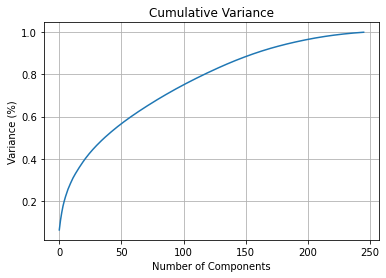

In [ ]:
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Cumulative Variance')
plt.grid()
plt.show()

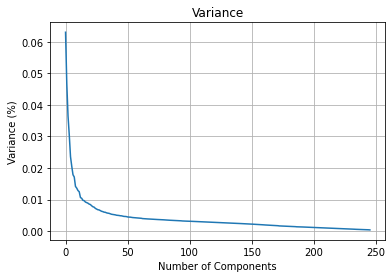

In [ ]:
#Plotting the Variance
plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Variance')
plt.grid()
plt.show()

In [ ]:
azdias_cleaned['real_class']= 0
customers_cleaned['real_class'] = 1

### K-Mean Clustering

In [ ]:
#K-Means Clustering
def clustering(df,center):
    print(center) #for monitoring purpose
    kmeans = KMeans(center)
    model = kmeans.fit(df)
    score = np.abs(model.score(df))
    return score

In [ ]:
%%time
pca_scores = []
centeriods = range(1,21)

for center in centeriods:
    pca_scores.append(clustering(azdias_cleaned.sample(20000),center))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
CPU times: user 7min 30s, sys: 28.2 s, total: 7min 58s
Wall time: 4min 3s


In [ ]:
print(pd.DataFrame(sorted(zip(centeriods, pca_scores),key = lambda x:x[1]), columns = ['centeroids','score']))

    centeroids         score
0           20  4.066376e+06
1           19  4.084936e+06
2           16  4.096682e+06
3           18  4.097949e+06
4           17  4.111294e+06
5           15  4.165664e+06
6           14  4.181616e+06
7           13  4.206332e+06
8           12  4.209389e+06
9           10  4.226990e+06
10          11  4.230024e+06
11           8  4.279058e+06
12           9  4.299930e+06
13           7  4.342256e+06
14           6  4.396892e+06
15           5  4.456978e+06
16           4  4.522106e+06
17           3  4.590756e+06
18           2  4.660307e+06
19           1  4.928520e+06


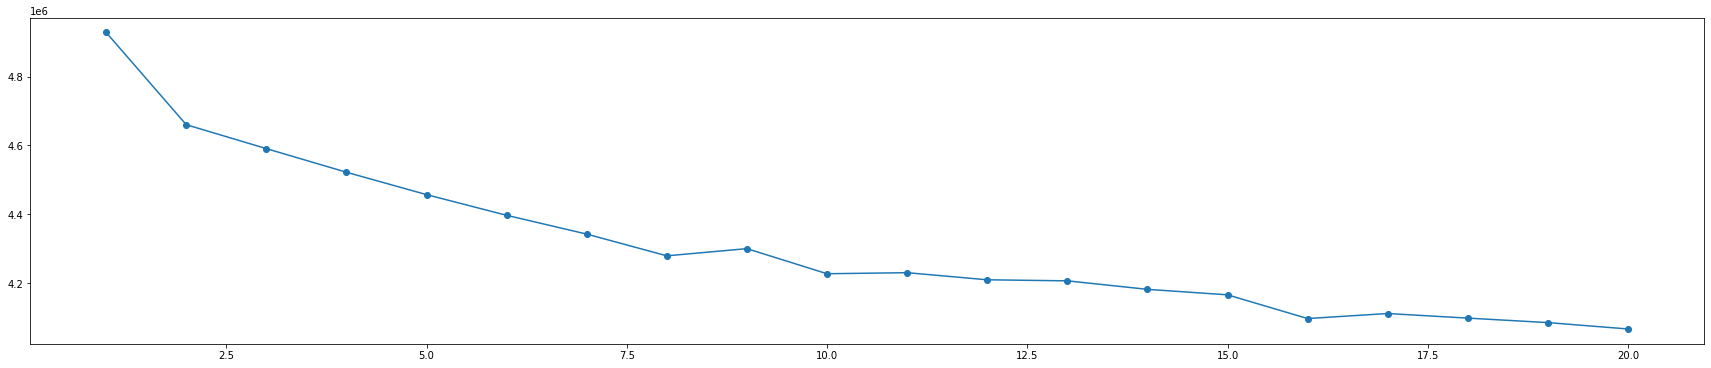

In [ ]:
plt.figure(figsize=(30,6))
plt.plot(centeriods,pca_scores,marker='o')

In [ ]:
pca = PCA().fit(azdias_cleaned)
azdiaz_pca = pca.transform(azdias_cleaned)
pca = PCA().fit(customers_cleaned)
customers_pca = pca.transform(customers_cleaned)

In [ ]:
kmeans = KMeans(10,random_state=123)
pop_cluster = kmeans.fit_predict(azdiaz_pca)
cus_cluster = kmeans.predict(customers_pca)

#### Final Conclusion

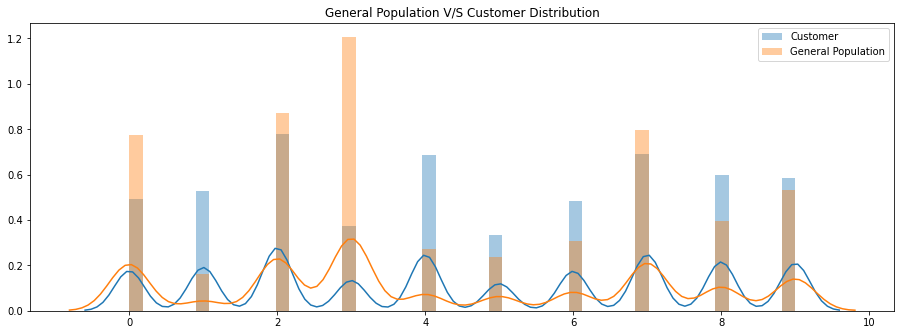

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1], title = 'General Population V/S Customer Distribution')
sns.distplot(pop_cluster, label = "Customer",ax=ax)
sns.distplot(cus_cluster, label = "General Population",ax=ax)
ax.legend()

**The above graphs shows that K-Means clustering with K = 10 helps to find customer from general public, it has very small difference, compared to others**